# Cryptocurrency Clustering

## Preliminaries

### Initial imports

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector
from sklearn.metrics import silhouette_score, silhouette_samples
from bokeh.models.formatters import NumeralTickFormatter

### Define Important Variables

In [3]:
# Define the random state for reproducibility
random_state = 42

# Flag to switch between analysis modes
do_homework_analysis = True  # otherwise, perform an alternative, exploratory analysis

# Plotting stuff
hvplot_width_default = 700
hvplot_height_default = 300
hvplot_width = 1000
hvplot_height = int(hvplot_height_default * (hvplot_width / hvplot_width_default))
hvplot_fontscale = 0.5 * ((hvplot_width / hvplot_width_default) + (hvplot_height / hvplot_height_default))

# Save figures to disk
save_figures = False

## Fetch Cryptocurrency Data Using Python

In [4]:
# If the flag `fetch_new_data` is set to `True`, this code will fetch data in
# real time from CryptoCompare.com and save a new, updated copy of the data
# to the local disk
fetch_new_data = False

if fetch_new_data:
    # Fetch new cryptocurrency data from CryptoCompare.com
    url = "https://min-api.cryptocompare.com/data/all/coinlist"
    req = requests.get(url)
    crypto_df = pd.DataFrame(req.json()['Data']).T

    # Save new data to local disk
    crypto_df.to_csv(Path('./data/crypto_data.csv'))

# Load data
crypto_df = pd.read_csv(Path('./data/crypto_data.csv'), index_col=0)

# Create a backup of the raw data for the analysis performed below (safety first)
crypto_df_save = crypto_df.copy()
crypto_df

Id                   Url                         ImageUrl  \
42      4321    /coins/42/overview           /media/35650717/42.jpg   
300   749869   /coins/300/overview          /media/27010595/300.png   
365    33639   /coins/365/overview            /media/352070/365.png   
404    21227   /coins/404/overview  /media/35650851/404-300x300.jpg   
433   926547   /coins/433/overview          /media/34836095/433.png   
...      ...                   ...                              ...   
ETNY  942946  /coins/etny/overview         /media/38553200/etny.png   
USDP  925939  /coins/usdp/overview          /media/37746929/pax.png   
SNY   943384   /coins/sny/overview          /media/38553461/sny.png   
TORG  943387  /coins/torg/overview         /media/38553462/torg.png   
ONEX  943389  /coins/onex/overview         /media/38553463/onex.png   

      ContentCreatedOn  Name Symbol         CoinName                FullName  \
42          1427211129    42     42          42 Coin            42 Coin (42)   
300         1517935016   300    300        300 token         300 token (300)   
365         1480032918   365    365          365Coin           365Coin (365)   
404         1466100361   404    404          404Coin           404Coin (404)   
433         1541597321   433    433        433 Token         433 Token (433)   
...                ...   ...    ...              ...                     ...   
ETNY        1628762024  ETNY   ETNY  Ethernity Cloud  Ethernity Cloud (ETNY)   
USDP        1539175944  USDP   USDP       Pax Dollar       Pax Dollar (USDP)   
SNY         1631631893   SNY    SNY      Synthetify        Synthetify  (SNY)   
TORG        1631699600  TORG   TORG             TORG             TORG (TORG)   
ONEX        1631703622  ONEX   ONEX         ONE TECH         ONE TECH (ONEX)   

                                            Description AssetTokenStatus  ...  \
42    Everything about 42 coin is 42 - apart from th...              NaN  ...   
300   300 token is an ERC20 token. This Token was cr...              NaN  ...   
365   365Coin is a Proof of Work and Proof of Stake ...              NaN  ...   
404   404 is a PoW/PoS hybrid cryptocurrency that al...              NaN  ...   
433   433 Token is a decentralised soccer platform t...         Finished  ...   
...                                                 ...              ...  ...   
ETNY  Ethernity Cloud restores the privacy of the us...         Upcoming  ...   
USDP  Pax Dollar (USDP) is a stable coin owned by Pa...              NaN  ...   
SNY   Built on Solana, Synthetify is a Decentralized...              NaN  ...   
TORG  TORG’s utility focus extends the notion of reg...              NaN  ...   
ONEX  ONEX is a Brazilian token for commercial excha...              NaN  ...   

     MaxSupply MktCapPenalty  IsUsedInDefi  IsUsedInNft PlatformType BuiltOn  \
42         0.0           0.0           0.0          0.0          NaN     NaN   
300      300.0           0.0           0.0          0.0        token     ETH   
365        0.0           0.0           0.0          0.0          NaN     NaN   
404        0.0           0.0           0.0          0.0          NaN     NaN   
433        NaN           NaN           NaN          NaN          NaN     NaN   
...        ...           ...           ...          ...          ...     ...   
ETNY       0.0           0.0           0.0          0.0          NaN     NaN   
USDP       NaN           NaN           NaN          NaN          NaN     NaN   
SNY        NaN           NaN           NaN          NaN          NaN     NaN   
TORG       NaN           NaN           NaN          NaN          NaN     NaN   
ONEX       NaN           NaN           NaN          NaN          NaN     NaN   

                            SmartContractAddress  DecimalPoints  Difficulty  \
42                                           NaN            NaN         NaN   
300   0xaec98a708810414878c3bcdf46aad31ded4a4557           18.0         NaN   
365                      

## Explore Data

In [5]:
# Quickly explore the dataframe by selecting a few relevant columns.  Here,
# we're looking at cryptocurrencies with CirculatingSupply > 0.
crypto_df_save[crypto_df_save['CirculatingSupply'] > 0][[
    'CoinName', 'FullName', 'IsTrading', 'ProofType', 'Algorithm', 'TotalCoinsMined', 'MaxSupply', 'CirculatingSupply',
]].sort_index()

CoinName                FullName  IsTrading  \
ADA             Cardano           Cardano (ADA)       True   
BCH        Bitcoin Cash      Bitcoin Cash (BCH)       True   
BITCI         Bitcicoin       Bitcicoin (BITCI)       True   
BSV          Bitcoin SV        Bitcoin SV (BSV)       True   
BTC             Bitcoin           Bitcoin (BTC)       True   
DOGE           Dogecoin         Dogecoin (DOGE)       True   
ETC    Ethereum Classic  Ethereum Classic (ETC)       True   
ETH            Ethereum          Ethereum (ETH)       True   
LINK          Chainlink        Chainlink (LINK)       True   
LTC            Litecoin          Litecoin (LTC)       True   
MATIC           Polygon         Polygon (MATIC)       True   
USDT             Tether           Tether (USDT)       True   
XRP                 XRP               XRP (XRP)       True   

                      ProofType  Algorithm  TotalCoinsMined     MaxSupply  \
ADA                         PoS  Ouroboros     3.236963e+10  4.500000e+10   
BCH                         PoW    SHA-256     1.884707e+07  2.100000e+07   
BITCI  Proof-of-Authority (PoA)        NaN     1.000000e+11 -1.000000e+00   
BSV                         PoW    SHA-256     1.884373e+07  2.100000e+07   
BTC                         PoW    SHA-256     1.881719e+07  2.100000e+07   
DOGE                        PoW     Scrypt     1.311620e+11 -1.000000e+00   
ETC                         PoW    EtcHash     1.284284e+08  2.107000e+08   
ETH                         PoW     Ethash     1.175427e+08 -1.000000e+00   
LINK                        NaN        NaN     1.000000e+09 -1.000000e+00   
LTC                         PoW     Scrypt     6.854322e+07  8.400000e+07   
MATIC                       NaN        NaN     1.000000e+10 -1.000000e+00   
USDT                        NaN        NaN     6.931328e+10 -1.000000e+00   
XRP         Federated Consensus        NaN     9.999026e+10  1.000000e+11   

       CirculatingSupply  
ADA         3.236963e+10  
BCH         1.884707e+07  
BITCI       1.038261e+10  
BSV         1.884373e+07  
BTC         1.881719e+07  
DOGE        1.311620e+11  
ETC         1.284284e+08  
ETH         1.175427e+08  
LINK        4.445096e+08  
LTC         6.854322e+07  
MATIC       6.446736e+09  
USDT        6.931328e+10  
XRP         4.662224e+10

## Perform Basic Data Preprocessing

In [6]:
# Get a fresh copy of the data
crypto_df = crypto_df_save.copy()

# Slice out a few interesting columns to analyze below
keep_columns = [
    'CoinName', 'Algorithm', 'IsTrading', 'ProofType', 'TotalCoinsMined', 'MaxSupply'#, 'CirculatingSupply'
]
crypto_df = crypto_df_save[keep_columns]

# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading'] == True]

# Drop the 'IsTrading' column
crypto_df = crypto_df.drop(columns='IsTrading')

# Remove cryptocurrencies that do not have an 'Algorithm'.  Note the tilde
# operator (`~`) for logical negation in the expression below.
crypto_df = crypto_df[~crypto_df['Algorithm'].isna()]

# Remove cryptocurrencies that do not have a 'ProofType'
crypto_df = crypto_df[~crypto_df['ProofType'].isna()]  # note tilde (`~`)

# Remove cryptocurrencies with one or more null value in the dataframe rows
crypto_df = crypto_df[crypto_df.isna().sum(axis=1) == 0]  # note tilde (`~`)

# Remove cryptocurrencies with no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined'] > 0]

# Remove cryptocurrencies that have `['N/A', 'None', 'Unknown']` text values
text_columns = make_column_selector(dtype_include=object)(crypto_df)  # `object` means `str` here
crypto_df = crypto_df[crypto_df[text_columns].isin(['N/A', 'None', 'Unknown']).sum(axis=1) == 0]

# Alphabetize the dataframe by index
crypto_df = crypto_df.sort_index()

# Add the fraction of coins mined -- be careful to avoid division by zero!
add_frac_coins_mined_label = 'FractionOfCoinsMined'  # for use below
frac_coins_mined_vals = []
for index, data in crypto_df.iterrows():
    if data['MaxSupply'] > 0:
        # Calculate the fractions of coins mined using "the usual formula"
        frac_coins_mined = data['TotalCoinsMined'] / data['MaxSupply']
    else:
        # These coins (e.g. ETH) have unlimited minable coins
        frac_coins_mined = -1
    # Add this result to the list
    frac_coins_mined_vals.append(frac_coins_mined)
# Add the fraction of coins mined to the dataframe
crypto_df[add_frac_coins_mined_label] = frac_coins_mined_vals
crypto_df

CoinName         Algorithm ProofType  TotalCoinsMined  \
AAC   Acute Angle Cloud         ECC 256K1      DPOS     1.000000e+09   
ACT              Achain              DPoS      DPoS     1.000000e+09   
ADA             Cardano         Ouroboros       PoS     3.236963e+10   
ADK        Aidos Kuneen             IMesh       PoW     2.500000e+07   
AEON               AEON  CryptoNight-Lite       PoW     1.794574e+07   
...                 ...               ...       ...              ...   
XVG               Verge          Multiple       PoW     1.647809e+10   
XWC           WhiteCoin            Scrypt   PoW/PoS     9.409917e+08   
ZEC               ZCash          Equihash       PoW     1.157956e+07   
ZEL             Zelcash          Equihash   PoW/PoS     4.400000e+08   
ZEN             Horizen          Equihash       PoW     1.152493e+07   

         MaxSupply  FractionOfCoinsMined  
AAC  -1.000000e+00             -1.000000  
ACT   0.000000e+00             -1.000000  
ADA   4.500000e+10              0.719325  
ADK   0.000000e+00             -1.000000  
AEON -1.000000e+00             -1.000000  
...            ...                   ...  
XVG   1.655500e+10              0.995354  
XWC   1.000000e+09              0.940992  
ZEC   2.100000e+07              0.551408  
ZEL   2.100000e+08              2.095238  
ZEN   2.100000e+07              0.548806  

[123 rows x 6 columns]

In [7]:
# Sanity check: Plot the fraction of total coins mined
hvplot_hist = crypto_df.hvplot.hist(
    y='FractionOfCoinsMined',
    bins=int(crypto_df.shape[0] / 4),
    title='Fraction of Total Coins Mined ("TotalCoinsMined" / "MaxSupply")',
    ylabel='Counts',
    grid=True,
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    xformatter=NumeralTickFormatter(format='0,0%')
)

if save_figures:
    hv.save(hvplot_hist, './images/crypto-fractions-coins-mined.png')

hvplot_hist

:Histogram   [FractionOfCoinsMined]   (FractionOfCoinsMined_count)

In [8]:
# Store the 'CoinName' in its own dataframe prior to dropping it from the dataframe
coin_names = crypto_df[['CoinName']]
coin_names

CoinName
AAC   Acute Angle Cloud
ACT              Achain
ADA             Cardano
ADK        Aidos Kuneen
AEON               AEON
...                 ...
XVG               Verge
XWC           WhiteCoin
ZEC               ZCash
ZEL             Zelcash
ZEN             Horizen

[123 rows x 1 columns]

In [9]:
# Remove the 'CoinName' from the dataframe since it won't be used in the analysis below
crypto_df = crypto_df.drop(columns='CoinName')
crypto_df

Algorithm ProofType  TotalCoinsMined     MaxSupply  \
AAC          ECC 256K1      DPOS     1.000000e+09 -1.000000e+00   
ACT               DPoS      DPoS     1.000000e+09  0.000000e+00   
ADA          Ouroboros       PoS     3.236963e+10  4.500000e+10   
ADK              IMesh       PoW     2.500000e+07  0.000000e+00   
AEON  CryptoNight-Lite       PoW     1.794574e+07 -1.000000e+00   
...                ...       ...              ...           ...   
XVG           Multiple       PoW     1.647809e+10  1.655500e+10   
XWC             Scrypt   PoW/PoS     9.409917e+08  1.000000e+09   
ZEC           Equihash       PoW     1.157956e+07  2.100000e+07   
ZEL           Equihash   PoW/PoS     4.400000e+08  2.100000e+08   
ZEN           Equihash       PoW     1.152493e+07  2.100000e+07   

      FractionOfCoinsMined  
AAC              -1.000000  
ACT              -1.000000  
ADA               0.719325  
ADK              -1.000000  
AEON             -1.000000  
...                    ...  
XVG               0.995354  
XWC               0.940992  
ZEC               0.551408  
ZEL               2.095238  
ZEN               0.548806  

[123 rows x 5 columns]

## Convert Categorical Variables into Dummy/Indicator Variables

In [10]:
if do_homework_analysis:
    # Drop 'FractionOfCoinsMined' in favor of ['TotalCoinsMined', 'MaxSupply']
    X = crypto_df.drop(columns=add_frac_coins_mined_label)
else:
    # Drop ['TotalCoinsMined', 'MaxSupply'] in favor of 'FractionOfCoinsMined'
    X = crypto_df.drop(columns=['TotalCoinsMined', 'MaxSupply'])

# Convert text/categorical variables into dummy/indicator variables
X = pd.get_dummies(X)
X

TotalCoinsMined     MaxSupply  Algorithm_Autolykos  Algorithm_BEP-2  \
AAC      1.000000e+09 -1.000000e+00                    0                0   
ACT      1.000000e+09  0.000000e+00                    0                0   
ADA      3.236963e+10  4.500000e+10                    0                0   
ADK      2.500000e+07  0.000000e+00                    0                0   
AEON     1.794574e+07 -1.000000e+00                    0                0   
...               ...           ...                  ...              ...   
XVG      1.647809e+10  1.655500e+10                    0                0   
XWC      9.409917e+08  1.000000e+09                    0                0   
ZEC      1.157956e+07  2.100000e+07                    0                0   
ZEL      4.400000e+08  2.100000e+08                    0                0   
ZEN      1.152493e+07  2.100000e+07                    0                0   

      Algorithm_BLAKE256  Algorithm_BMW512 / Echo512  \
AAC                    0                           0   
ACT                    0                           0   
ADA                    0                           0   
ADK                    0                           0   
AEON                   0                           0   
...                  ...                         ...   
XVG                    0                           0   
XWC                    0                           0   
ZEC                    0                           0   
ZEL                    0                           0   
ZEN                    0                           0   

      Algorithm_Blake2B + SHA3  Algorithm_Blake2b  Algorithm_C31  \
AAC                          0                  0              0   
ACT                          0                  0              0   
ADA                          0                  0              0   
ADK                          0                  0              0   
AEON                         0                  0              0   
...                        ...                ...            ...   
XVG                          0                  0              0   
XWC                          0                  0              0   
ZEC                          0                  0              0   
ZEL                          0                  0              0   
ZEN                          0                  0              0   

      Algorithm_CryptoNight  ...  ProofType_PoW/PoS  ProofType_PoW/PoSe  \
AAC                       0  ...                  0                   0   
ACT                       0  ...                  0                   0   
ADA                       0  ...                  0                   0   
ADK                       0  ...                  0                   0   
AEON                      0  ...                  0                   0   
...                     ...  ...                ...                 ...   
XVG                       0  ...                  0                   0   
XWC                       0  ...                  1                   0   
ZEC                       0  ...                  0                   0   
ZEL                       0  ...                  1                   0   
ZEN                       0  ...                  0                   0   

      ProofType_PoW/nPoS  ProofType_Proof of Authority  ProofType_SPoS  \
AAC                    0                             0               0   
ACT                    0                             0               0   
ADA                    0                             0               0   
ADK                    0                             0               0   
AEON                   0                             0               0   
...                  ...                           ...             ...   
XVG                    0                             0               0   
XWC                    0                             0               0   
ZEC                    0

## Standardize Data

In [11]:
# Standardize the data using Scikit-Learn's `StandardScaler`
if do_homework_analysis:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)  # convert to DataFrame
else:
    # No need to standardize the data since all features are already on the same
    # scale, i.e. approximately ~1
    X_scaled = X.copy()

X_scaled

TotalCoinsMined  MaxSupply  Algorithm_Autolykos  Algorithm_BEP-2  \
AAC         -0.165752  -0.133420            -0.090536        -0.090536   
ACT         -0.165752  -0.133420            -0.090536        -0.090536   
ADA          0.080929   0.357873            -0.090536        -0.090536   
ADK         -0.173419  -0.133420            -0.090536        -0.090536   
AEON        -0.173474  -0.133420            -0.090536        -0.090536   
...               ...        ...                  ...              ...   
XVG         -0.044037   0.047322            -0.090536        -0.090536   
XWC         -0.166216  -0.122502            -0.090536        -0.090536   
ZEC         -0.173524  -0.133190            -0.090536        -0.090536   
ZEL         -0.170155  -0.131127            -0.090536        -0.090536   
ZEN         -0.173525  -0.133190            -0.090536        -0.090536   

      Algorithm_BLAKE256  Algorithm_BMW512 / Echo512  \
AAC            -0.128565                   -0.090536   
ACT            -0.128565                   -0.090536   
ADA            -0.128565                   -0.090536   
ADK            -0.128565                   -0.090536   
AEON           -0.128565                   -0.090536   
...                  ...                         ...   
XVG            -0.128565                   -0.090536   
XWC            -0.128565                   -0.090536   
ZEC            -0.128565                   -0.090536   
ZEL            -0.128565                   -0.090536   
ZEN            -0.128565                   -0.090536   

      Algorithm_Blake2B + SHA3  Algorithm_Blake2b  Algorithm_C31  \
AAC                  -0.090536          -0.128565      -0.128565   
ACT                  -0.090536          -0.128565      -0.128565   
ADA                  -0.090536          -0.128565      -0.128565   
ADK                  -0.090536          -0.128565      -0.128565   
AEON                 -0.090536          -0.128565      -0.128565   
...                        ...                ...            ...   
XVG                  -0.090536          -0.128565      -0.128565   
XWC                  -0.090536          -0.128565      -0.128565   
ZEC                  -0.090536          -0.128565      -0.128565   
ZEL                  -0.090536          -0.128565      -0.128565   
ZEN                  -0.090536          -0.128565      -0.128565   

      Algorithm_CryptoNight  ...  ProofType_PoW/PoS  ProofType_PoW/PoSe  \
AAC               -0.128565  ...          -0.492366           -0.090536   
ACT               -0.128565  ...          -0.492366           -0.090536   
ADA               -0.128565  ...          -0.492366           -0.090536   
ADK               -0.128565  ...          -0.492366           -0.090536   
AEON              -0.128565  ...          -0.492366           -0.090536   
...                     ...  ...                ...                 ...   
XVG               -0.128565  ...          -0.492366           -0.090536   
XWC               -0.128565  ...           2.031010           -0.090536   
ZEC               -0.128565  ...          -0.492366           -0.090536   
ZEL               -0.128565  ...           2.031010           -0.090536   
ZEN               -0.128565  ...          -0.492366           -0.090536   

      ProofType_PoW/nPoS  ProofType_Proof of Authority  ProofType_SPoS  \
AAC            -0.090536                     -0.090536       -0.090536   
ACT            -0.090536                     -0.090536       -0.090536   
ADA            -0.090536                     -0.090536       -0.090536   
ADK            -0.090536                     -0.090536       -0.090536   
AEON           -0.090536                     -0.090536       -0.090536   
...                  ...                           ...             ...   
XVG            -0.090536                     -0.090536       -0.090536   
XWC            -0.090536                     -0.090536       -0.090536   
ZEC            -0.090536                     -0.090536      

## Perform Dimensionality Reduction Using PCA/SVD

Remember, the total number of eigenvalues is set by `min(nrows, ncols)` of the input-feature dataframe, `X`.

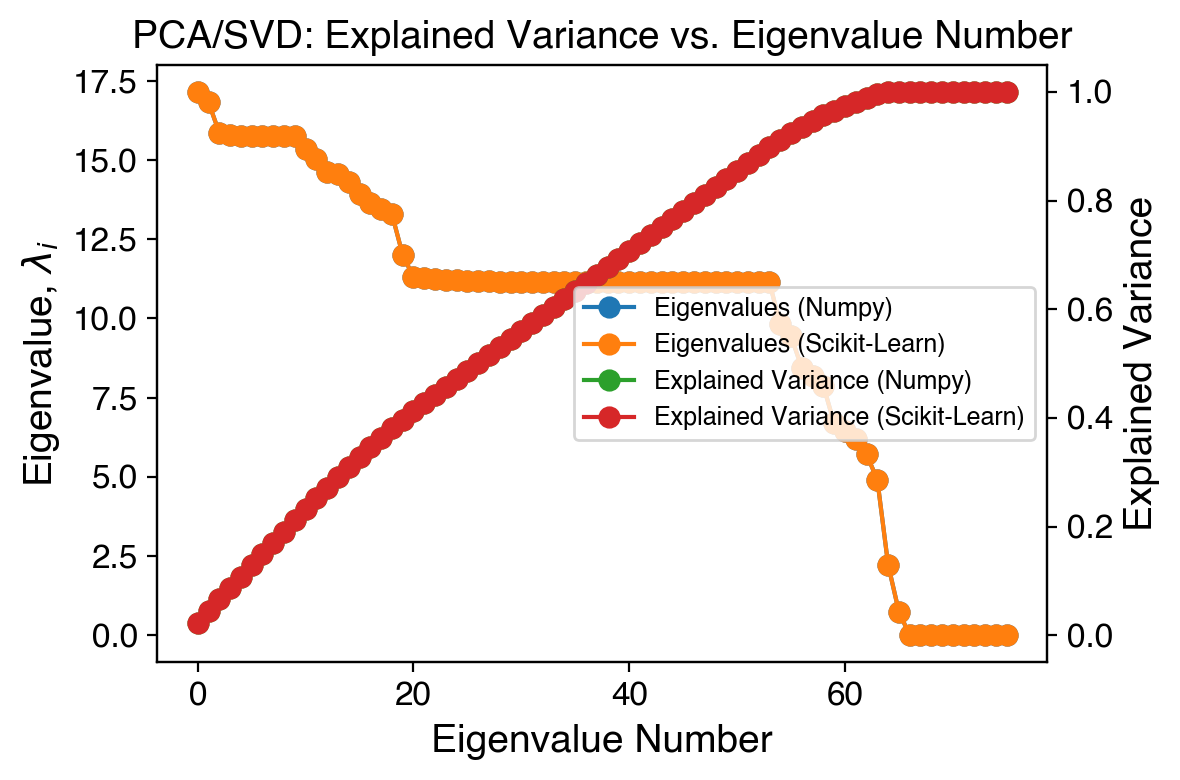

In [21]:
# Method 1: Singluar Value Decomposition (SVD) using Numpy
UU, S, VVT = np.linalg.svd(X_scaled)

# Method 2: Principal Component Analysis (PCA) / SVD using Scikit-Learn
pca_decomp = PCA(n_components=None, random_state=random_state)
X_scaled_pca = pca_decomp.fit_transform(X_scaled)
X_scaled_pca = pd.DataFrame(data=X_scaled_pca, columns=X_scaled.columns, index=X_scaled.index)

# Plot the results
fig, ax1 = plt.subplots()

# First plot: Eigenvalues vs. Eigenvalue Number
eigvals = S
ax1.plot(range(len(eigvals)), eigvals, 'o-', label='Eigenvalues (Numpy)')
#ax1.plot(range(len(eigvals)), (eigvals / np.sum(eigvals)), 'o-', label='Explained-Variance Ratio (Numpy)')
eigvals = pca_decomp.singular_values_
ax1.plot(range(len(eigvals)), eigvals, 'o-', label='Eigenvalues (Scikit-Learn)')
#ax1.plot(range(len(eigvals)), (eigvals / np.sum(eigvals)), 'o-', label='Explained-Variance Ratio (Scikit-Learn)')
ax1.grid(False)
ax1.set_title('PCA/SVD: Explained Variance vs. Eigenvalue Number')
ax1.set_ylabel('Eigenvalue, $\lambda_i$')
ax1.set_xlabel('Eigenvalue Number')

# Second plot: Explained Variance vs. Eigenvalue Number
ax2 = ax1.twinx()
eigvals = S
ax2.plot(range(len(eigvals)), (np.cumsum(eigvals) / np.sum(eigvals)), 'o-', color='C2', label='Explained Variance (Numpy)')
eigvals = pca_decomp.singular_values_
ax2.plot(range(len(eigvals)), (np.cumsum(eigvals) / np.sum(eigvals)), 'o-', color='C3', label='Explained Variance (Scikit-Learn)')
ax2.grid(False)
ax2.set_ylabel('Explained Variance')
ax2.set_ylim(-0.05, 1.05)

# Combine plot legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend((h1 + h2), (l1 + l2), loc='center right')

# Finalize plot
plt.tight_layout()
plt.show()

if save_figures:
    if do_homework_analysis:
        fig.savefig('./images/pca-explained-variance-standard-scaler.png', dpi=300)
    else:
        fig.savefig('./images/pca-explained-variance.png', dpi=300)

In [13]:
# Create a DataFrame in which the input feature space is projected onto
# the top 3 principal components (i.e. perform dimensionality reduction)
pca_df = X_scaled_pca.iloc[:, :3]
pca_df.columns = [f"PC{n + 1}" for n in range(pca_df.shape[1])]
pca_df

PC1       PC2       PC3
AAC  -1.969769  0.043671  1.712458
ACT  -1.204410  3.345615 -2.171019
ADA  -1.481137  0.812125 -0.534932
ADK   0.937253 -0.716941 -0.073150
AEON  1.383886 -0.820013 -0.121404
...        ...       ...       ...
XVG   1.529857 -0.662214 -0.090337
XWC  -1.216173 -0.557161 -0.239569
ZEC   1.076376 -0.805713 -0.118297
ZEL  -0.831911 -0.581172 -0.165029
ZEN   1.076376 -0.805714 -0.118297

[123 rows x 3 columns]

## Perform Clustering with K-Means

### Make "Elbow Plot"

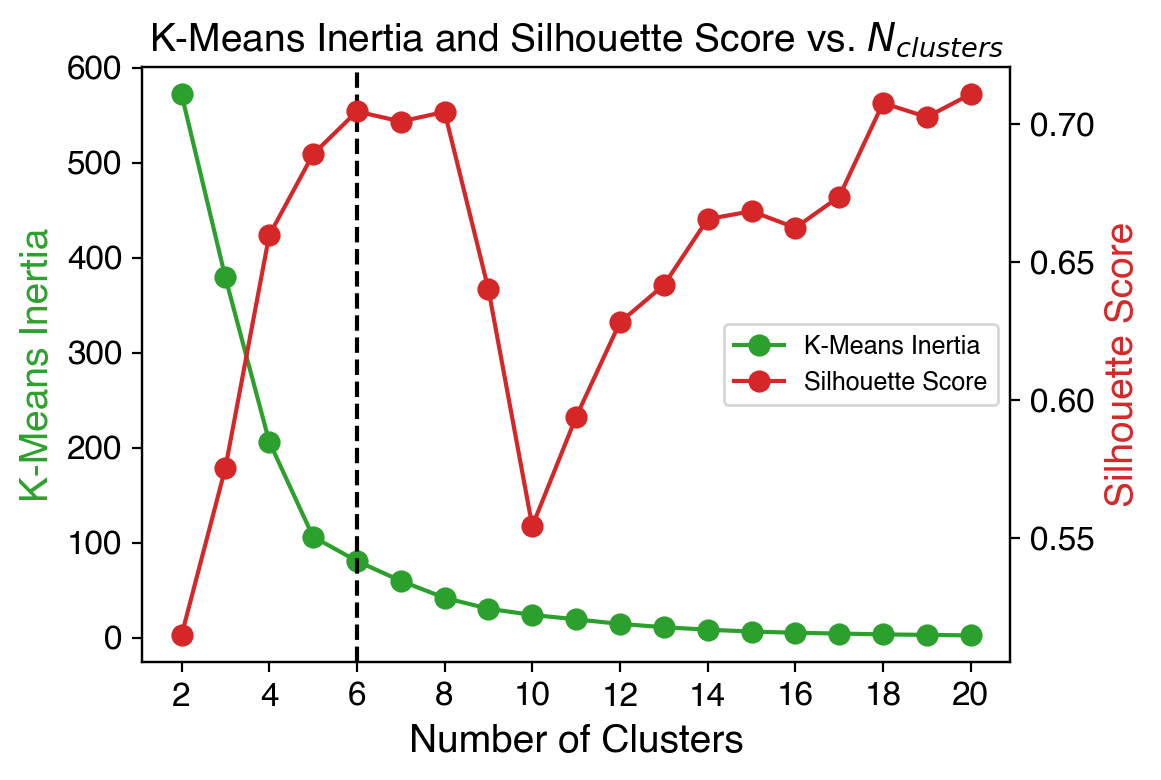

In [14]:
the_thing_to_cluster = pca_df.copy()

# Calculate inertias and silhouette coefficients for several different clusters
n_clusters_list = list(range(2, 21))
kmeans_inertias = []
silhouette_avgs = []
for n_clusters in n_clusters_list:
    # Define the K-Means clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    # Label the clusters of the input data
    cluster_labels = clusterer.fit_predict(the_thing_to_cluster)
    # Calculate cluster inertia
    kmeans_inertia = clusterer.inertia_
    # Calculate silhouette coefficient
    silhouette_avg = silhouette_score(the_thing_to_cluster, cluster_labels)
    # Append data to list
    kmeans_inertias.append(kmeans_inertia)
    silhouette_avgs.append(silhouette_avg)

# Create the so-called "elbow curve" plot
fig, ax1 = plt.subplots()
ax1.plot(n_clusters_list, kmeans_inertias, 'o-', label='K-Means Inertia', color='C2')
ax1.grid(False)
ax1.set_title('K-Means Inertia and Silhouette Score vs. Number of Clusters')
ax1.set_title('K-Means Inertia and Silhouette Score vs. $N_{clusters}$')
ax1.set_ylabel('K-Means Inertia', color='C2')
ax1.set_xlabel('Number of Clusters')
ax1.set_xticks(n_clusters_list[::2])

ax2 = ax1.twinx()
ax2.plot(n_clusters_list, silhouette_avgs, 'o-', label='Silhouette Score', color='C3')
ax2.grid(False)
ax2.set_ylabel('Silhouette Score', color='C3')
#ax2.set_ylim(-0.05, 1.05)

# Combine legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend((h1 + h2), (l1 + l2), loc='center right')

# Add a vertical line for the optimal number of clusters
if do_homework_analysis:
    n_clusters_best = 6
else:
    n_clusters_best = 7
ax1.axvline(n_clusters_best, color='k', linestyle='--')

# Finalize plot
plt.tight_layout()
plt.show()

if save_figures:
    fig.savefig('./images/kmeans-elbow-plot.png', dpi=300)

### Make Silhouette Plots

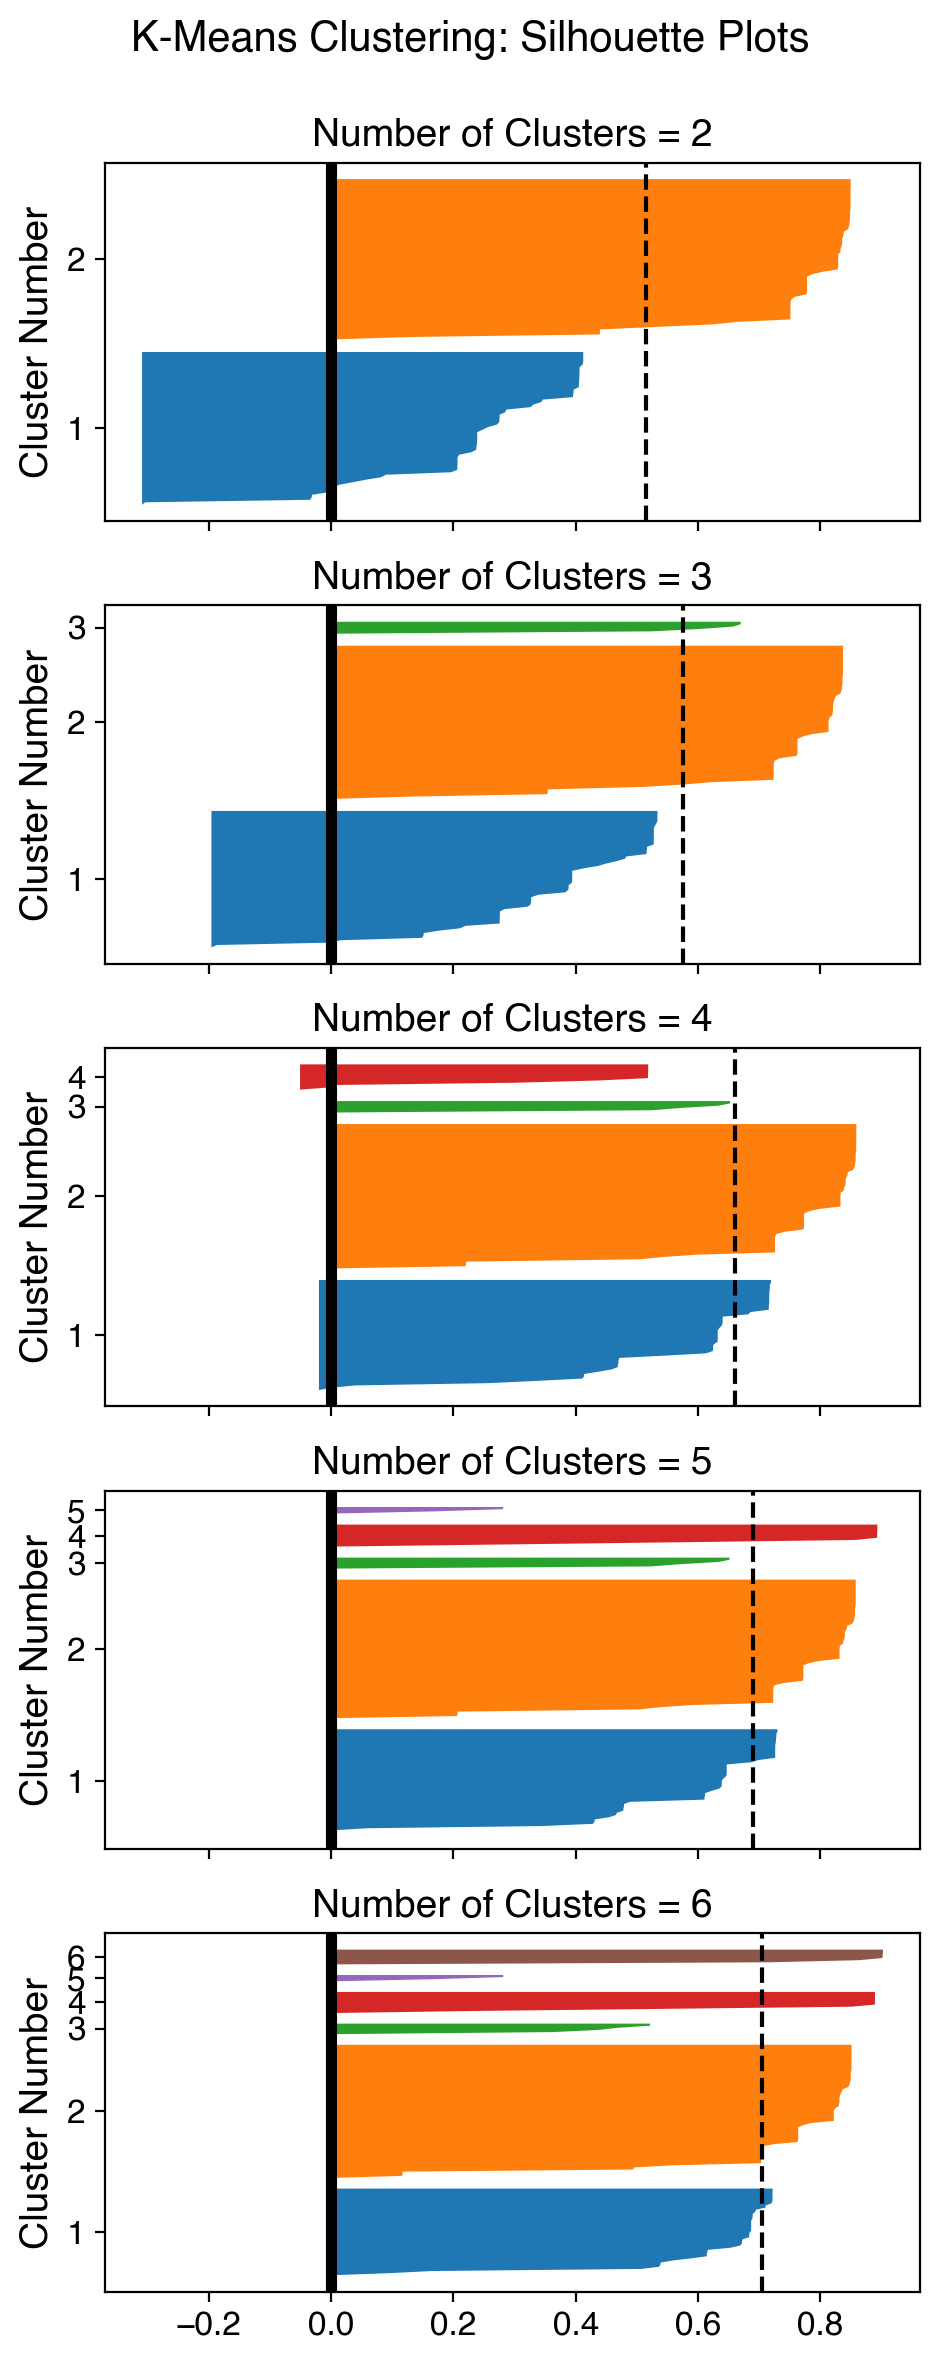

In [15]:
if do_homework_analysis:
    n_clusters_list = [2, 3, 4, 5, 6]
else:
    n_clusters_list = [2, 3, 4, 5, 6, 7, 8]

figx, figy = plt.rcParams['figure.figsize']
fig, axs = plt.subplots(
    nrows=len(n_clusters_list),
    figsize=((0.8 * figx), (0.6 * len(n_clusters_list) * figy)),
    sharex=True
)
fill_alpha = 1.0
y_spacing = 5

for (idx_n_clusters, n_clusters) in enumerate(n_clusters_list):
    ax = axs[idx_n_clusters]
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(the_thing_to_cluster)
    
    silhouette_vals = silhouette_samples(the_thing_to_cluster, cluster_labels)
    silhouette_avg = silhouette_score(the_thing_to_cluster, cluster_labels)
    
    y_ticks = []
    y_ticklabels = []
    y_min = y_spacing
    for n in range(n_clusters):
        nth_cluster_silhouette_vals = silhouette_vals[cluster_labels == n]
        if np.sum(nth_cluster_silhouette_vals == 0.0) == 0:
            nth_cluster_silhouette_vals = np.append(nth_cluster_silhouette_vals, [0.0])
        nth_cluster_silhouette_vals.sort()
        
        size_cluster_n = nth_cluster_silhouette_vals.shape[0]
        y_max = y_min + size_cluster_n
        
        ax.fill_between(
            nth_cluster_silhouette_vals,
            np.arange(y_min, y_max),
            y_max,
            alpha=fill_alpha,
        )
        
        y_ticks.append(0.5 * (y_max + y_min))
        y_ticklabels.append(n + 1)
        
        y_min = y_max + y_spacing
    
    ax.set_title(f"Number of Clusters = {n_clusters}")
    ax.set_ylabel(f"Cluster Number")
    #ax.set_xlabel(f"Silhouette Score")
    ax.axvline(x=0, color='black', lw=4)
    ax.axvline(silhouette_avg, color='black', linestyle='--', lw=1.5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    ax.grid(False)

fig.suptitle('K-MEANS CLUSTERING: SILHOUETTE PLOTS\n')
fig.suptitle('K-Means Clustering: Silhouette Plots\n')
plt.tight_layout()
plt.show()

if save_figures:
    fig.savefig('./images/kmeans-silhouette-plots.png', dpi=300)

### Run K-Means with Optimal `n_clusters`

In [16]:
# Initialize the K-Means model
kmeans_best = KMeans(n_clusters=n_clusters_best, random_state=random_state)

# Fit the model and predict the cluster class labels
kmeans_best_labels = kmeans_best.fit_predict(the_thing_to_cluster)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
kmeans_best_df = pd.DataFrame(
    data=(1 + kmeans_best_labels),
    index=the_thing_to_cluster.index,
    columns=['Class']
)

# Construct the final dataframe
clustered_df = pd.concat(
    [
        #X_scaled,
        coin_names,
        crypto_df,
        pca_df,
        kmeans_best_df
    ],
    axis=1,
    join='inner',
)
clustered_df

CoinName         Algorithm ProofType  TotalCoinsMined  \
AAC   Acute Angle Cloud         ECC 256K1      DPOS     1.000000e+09   
ACT              Achain              DPoS      DPoS     1.000000e+09   
ADA             Cardano         Ouroboros       PoS     3.236963e+10   
ADK        Aidos Kuneen             IMesh       PoW     2.500000e+07   
AEON               AEON  CryptoNight-Lite       PoW     1.794574e+07   
...                 ...               ...       ...              ...   
XVG               Verge          Multiple       PoW     1.647809e+10   
XWC           WhiteCoin            Scrypt   PoW/PoS     9.409917e+08   
ZEC               ZCash          Equihash       PoW     1.157956e+07   
ZEL             Zelcash          Equihash   PoW/PoS     4.400000e+08   
ZEN             Horizen          Equihash       PoW     1.152493e+07   

         MaxSupply  FractionOfCoinsMined       PC1       PC2       PC3  Class  
AAC  -1.000000e+00             -1.000000 -1.969769  0.043671  1.712458      6  
ACT   0.000000e+00             -1.000000 -1.204410  3.345615 -2.171019      4  
ADA   4.500000e+10              0.719325 -1.481137  0.812125 -0.534932      1  
ADK   0.000000e+00             -1.000000  0.937253 -0.716941 -0.073150      2  
AEON -1.000000e+00             -1.000000  1.383886 -0.820013 -0.121404      2  
...            ...                   ...       ...       ...       ...    ...  
XVG   1.655500e+10              0.995354  1.529857 -0.662214 -0.090337      2  
XWC   1.000000e+09              0.940992 -1.216173 -0.557161 -0.239569      1  
ZEC   2.100000e+07              0.551408  1.076376 -0.805713 -0.118297      2  
ZEL   2.100000e+08              2.095238 -0.831911 -0.581172 -0.165029      1  
ZEN   2.100000e+07              0.548806  1.076376 -0.805714 -0.118297      2  

[123 rows x 10 columns]

## Visualizing Results

### 3D-Scatter Plot with Cryptocurrency Clusters

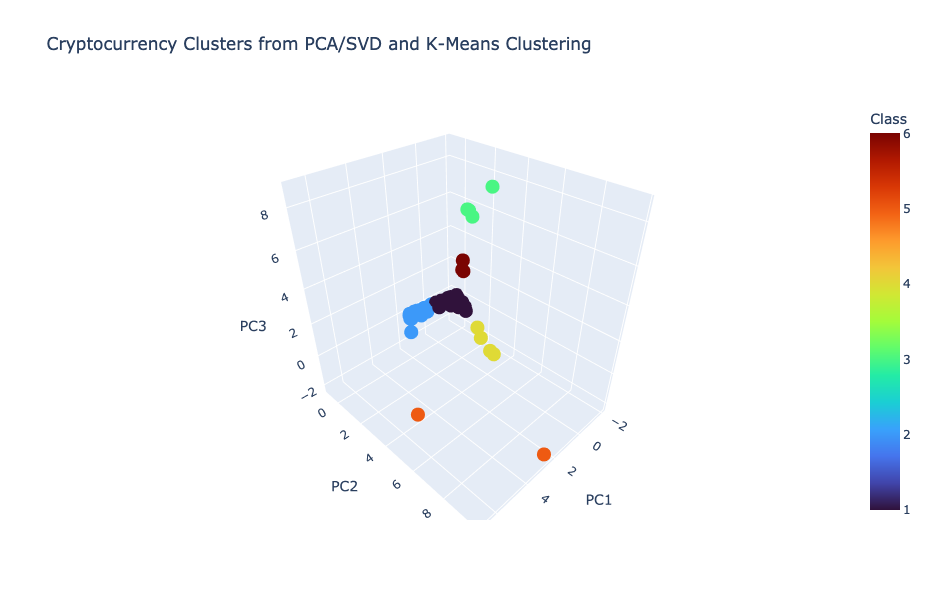

In [50]:
# Create a 3D scatter plot with results from PCA + K-Means clustering
fig = px.scatter_3d(
    clustered_df, #[clustered_df['Class'] <= 4],
    x='PC1',
    y='PC2',
    z='PC3',
    color='Class',
    color_continuous_scale='turbo',
    width=600,
    height=600,
    hover_name='CoinName',
    hover_data=None,
    title='Cryptocurrency Clusters from PCA/SVD and K-Means Clustering'
)
fig.show()

<img src="./images/splash-1.jpg" width="600px"></img>

### Table of Tradable Cryptocurrencies

In [47]:
# Table with tradable cryptos
hvplot_table = clustered_df.hvplot.table(
    columns=[
        'CoinName',
        "Algorithm",
        "ProofType",
        "MaxSupply",
        "TotalCoinsMined",
        'Class'
    ],
    sortable=True,
    selectable=True,
    width=800,
    height=400,
)

hvplot_table

:Table   [CoinName,Algorithm,ProofType,MaxSupply,TotalCoinsMined,Class]

### Scatter Plot with Tradable Cryptocurrencies

In [20]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
hvplot_scatter = clustered_df.hvplot.scatter(
    x='MaxSupply',
    y='TotalCoinsMined',
    c='Class',
    s=17**2,
    hover_cols=['CoinName'],
    title='Total Crypto Coins Mined vs. Max Supply',
    clabel='Class',
    cmap='jet',
    grid=True,
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
)
#hv.save(hvplot_scatter, './images/crypto-coins-mined-vs-max-supply.png')
hvplot_scatter

:Scatter   [MaxSupply]   (TotalCoinsMined,Class,CoinName)